# Working on the blockchain gang: Crunching and visualizing bitcoin data

by Benedikt Koehler, CEO and Founder of DataLion (Munich, Germany)

Presentation at Strata + Hadoop World 2016 in San Jose, CA

## Getting the Data

To initially download the Blockchain database you need to install a Bitcoin client. Either the GUI-version or the headless (non-GUI) version:

- https://bitcoin.org/de/download

On a Mac you can also install the bitcoind client with homebrew:

```
$ brew install bitcoind
```

If you start the client it will download the whole Blockchain into your Bitcoin directory. Typical locations where the files will be downloaded to are:
- C:\Documents and Settings\YourUserName\Application data\Bitcoin (Win XP)
- C:\Users\YourUserName\Appdata\Roaming\Bitcoin (Vista, Win 7)
- ~/.bitcoin/ (Linux)
- ~/Library/Application Support/Bitcoin/ (Mac)

For an even quicker startup, you can also download the Blockchain via Bittorrent:

- https://bitcoin.org/bin/block-chain/

In [25]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import csv
import networkx as nx
%pylab inline

# Directory where the processed transaction files can be found
btcdir = '/Users/koehler/python/Bitcoin-Transaction-Network-Extraction/bitcoin_transactions/'

# Originally directory with the blockchain data
blockdir = '/Users/koehler/Documents/blockchain/blocks/'

Populating the interactive namespace from numpy and matplotlib


## Taking a look at the binary data

First, we take a look at the binary data as they are present in the blocks directory. The file format is specified as follows:
![Bitcoin file format](http://2.bp.blogspot.com/-DaJcdsyqQSs/UsiTXNHP-0I/AAAAAAAATC0/kiFRowh-J18/s1600/blockchain.png)
If you look at the script portion of the transaction data, sometimes, you can find unexpected things.

Here's some interesting locations:
- Genesis Block with message from Satoshi Nakamoto (blk00000.dat, 0)
- Tribute to Len (blk00003.dat, 46130955)
- Prayer to Eligius (blk00003.dat, 62215783)
- I Like Big Blocks (blk00276.dat, 81785600)
- Cannabis leaf (blk00277.dat, 88535801)

Also: Image, Cablegate files ...

In [58]:
import binascii
location = 88535801
blockfile = "blk00277.dat"

output = ""
ascii = ""
with open(blockdir + blockfile, "rb") as f:
    f.seek(location)
    byte = f.read(2000)
    hex = str(binascii.hexlify(byte), 'ascii')
    output = ' '.join(hex[i:i+2] for i in range(0, len(hex), 2))

    for b in byte:
        #if (b < 128) and (b > 31):
        ascii = ascii + str(chr(b))



print(output)
print()
print(ascii.replace("@","\n"))

20 20 20 20 20 20 34 4d 4d 4d 4c 20 20 20 20 20 20 20 20 20 88 ac 22 02 00 00 00 00 00 00 19 76 a9 14 20 20 20 20 20 20 20 20 20 2e 0a 20 20 20 20 20 20 20 20 20 88 ac 22 02 00 00 00 00 00 00 19 76 a9 14 20 20 20 20 20 20 20 20 20 4d 4d 4d 4d 4d 2e 20 20 20 20 20 88 ac 22 02 00 00 00 00 00 00 19 76 a9 14 20 20 20 20 20 20 20 20 20 20 20 78 66 0a 20 20 2e 20 20 20 88 ac 22 02 00 00 00 00 00 00 19 76 a9 14 20 20 20 20 20 20 20 20 20 20 20 22 4d 36 4d 4d 4d 20 20 20 88 ac 22 02 00 00 00 00 00 00 19 76 a9 14 20 20 20 20 20 20 20 20 20 20 20 20 2e 4d 4d 2d 0a 20 20 20 88 ac 22 02 00 00 00 00 00 00 19 76 a9 14 4d 68 2e 2e 20 20 20 20 20 20 20 20 20 20 2b 4d 4d 35 4d 4d 88 ac 22 02 00 00 00 00 00 00 19 76 a9 14 4d 20 20 20 20 20 20 20 20 20 20 20 20 2e 4d 4d 4d 4d 0a 20 88 ac 22 02 00 00 00 00 00 00 19 76 a9 14 20 20 2e 4d 4d 4d 2e 20 20 20 20 20 20 20 20 20 2e 4d 4d 4d 88 ac 22 02 00 00 00 00 00 00 19 76 a9 14 4d 4d 4c 2e 20 20 20 20 20 20 20 20 20 20 4d 4d 4d 4d 4d 68 88 ac 22 02 00 00 00 0

In [10]:
import struct 
 
def uint1(stream):
    return ord(stream.read(1)) 
 
def uint2(stream):
    return struct.unpack('H', stream.read(2))[0] 
 
def uint4(stream):
    return struct.unpack('I', stream.read(4))[0] 
 
def uint8(stream):
    return struct.unpack('Q', stream.read(8))[0] 
 
def hash32(stream):
    return stream.read(32)[::-1] 
 
def time(stream):
    time = uint4(stream) 
    return time 
 
def varint(stream):
    size = uint1(stream)
    if size < 0xfd: 
        return size
    if size == 0xfd: 
        return uint2(stream)
    if size == 0xfe: 
        return uint4(stream)
    if size == 0xff: 
        return uint8(stream)
    return -1 
 
def hashStr(bytebuffer): 
    return ''.join(('%x'%ord(a)) for a in bytebuffer)

In [47]:
blockfile = blockdir + "blk00000.dat"
with open(blockfile, "rb") as blockfile: 
      print "Magic Number:\t %8x" % uint4(blockfile) 
      print "Blocksize:\t %d" % uint4(blockfile) 
 
      """Block Header""" 
      print "Version:\t %d" % uint4(blockfile) 
      print "Previous Hash\t %s" % hashStr(hash32(blockfile)) 
      print "Merkle Root\t %s" % hashStr(hash32(blockfile)) 
      print "Time\t\t %s" % str(time(blockfile)) 
      print "Difficulty\t %8x" % uint4(blockfile) 
      print "Nonce\t\t %s" % uint4(blockfile) 
 
      print "Tx Count\t %d" % varint(blockfile) 
 
      print "Version Number\t %s" % uint4(blockfile) 
      print "Inputs\t\t %s" % varint(blockfile) 
      print "Previous Tx\t %s" % hashStr(hash32(blockfile)) 
      print "Prev Index \t %d" % uint4(blockfile) 
      script_len = varint(blockfile) 
      print "Script Length\t %d" % script_len 
      script_sig = blockfile.read(script_len) 
      print "ScriptSig\t %s" % hashStr(script_sig) 
      print "ScriptSig\t %s" % hashStr(script_sig).decode('hex') 
      print "Seq Num\t\t %8x" % uint4(blockfile) 
 
      print "Outputs\t\t %s" % varint(blockfile) 
      print "Value\t\t %s" % str((uint8(blockfile)*1.0)/100000000.00) 
      script_len = varint(blockfile) 
      print "Script Length\t %d" % script_len 
      script_pubkey = blockfile.read(script_len) 
      print "Script Pub Key\t %s" % hashStr(script_pubkey) 
      print "Lock Time %8x" % uint4(blockfile) 
      print
      print "Magic Number:\t %8x" % uint4(blockfile) 
      print " ... "

Magic Number:	 d9b4bef9
Blocksize:	 285
Version:	 1
Previous Hash	 00000000000000000000000000000000
Merkle Root	 4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc77ab2127b7afdeda33b
Time		 1231006505
Difficulty	 1d00ffff
Nonce		 2083236893
Tx Count	 1
Version Number	 1
Inputs		 1
Previous Tx	 00000000000000000000000000000000
Prev Index 	 4294967295
Script Length	 77
ScriptSig	 4ffff01d14455468652054696d65732030332f4a616e2f32303039204368616e63656c6c6f72206f6e206272696e6b206f66207365636f6e64206261696c6f757420666f722062616e6b73
ScriptSig	 O��EThe Times 03/Jan/2009 Chancellor on brink of second bailout for banks
Seq Num		 ffffffff
Outputs		 1
Value		 50.0
Script Length	 67
Script Pub Key	 414678afdb0fe5548271967f1a67130b7105cd6a828e0399a67962e0ea1f61deb649f6bc3f4cef38c4f3554e51ec112de5c384df7bab8d578a4c702b6bf11d5fac
Lock Time        0

Magic Number:	 d9b4bef9
 ... 


## Data-sets used for this analysis

Our analyses are based on three files in a very simple plaintext network format:

### 1. transactions.csv

This file contains all links between transactions. This file is needed to calculate the transaction network that allows to "follow the money" between transactions. Each Bitcoin transaction can have one or multiple inputs that originate in previous transactions and one or multiple outputs that can be the input for subsequent transaction. If a transaction is not (yet) appearing as input to another transactions, the coins associated with this address are "unspent".

This file looks like this:
```
from_transaction;to_transaction;timestamp;value
2fd05281e6465a2e44569c0f113599072ee95dc08c202fb8726a9103f1f4c4c9;048ed7f0da235da66b581539666443192b4ac2ef76f0baf1599eb972e03b16ae;2014-05-20-11-01-03;5.17
ccde41fcd84136ec528fd1019ab8441bb6bb2f7043055764403aab5fce1aa136;55b28a91e41bb8b2fd3e1e3edf198ac2f2e6442f47afaa6f71a61d45259846d4;2014-05-20-11-01-03;13.7
6d65e6521217d0c11ddc9ba99ce86c0e64af7f0f4c0842bdc9b0cc98090b9d9e;55b28a91e41bb8b2fd3e1e3edf198ac2f2e6442f47afaa6f71a61d45259846d4;2014-05-20-11-01-03;13.7
```

### 2. user_transactions.csv

Here, the focus is on the links between users, so this structure is more like a social network than a transaction network. To create this network, we need to "create" users out of the public addresses that can be found in the Blockchain. This is because one user can have - and usually has - private keys for multiple public addresses that contain Bitcoins.

This file looks like this:
```
from_user_id;to_user_id;timestamp
4367099;3406235;50;2009-01-11-20-03-17
4367099;242039;50;2009-01-11-20-07-44
4367099;15929939;50;2009-01-11-23-01-57
```


### 3. user_hashes.csv

This file contains the user ids - numbered 0, 1, 2 ... - and all the public keys that have been seen together as inputs. Keys that are used as input for a transaction can be assumed to belong to the same user because to perform this transaction, all the secret keys must be available. Although this approach to create users is quite common, there are a few caveats. E.g. one common approach to anonymize Bitcoin transactions are "mixing clouds" where multiple inputs are mixed by a platform and then again distributed among the participating users. In this case the inputs may or may not belong to the same user.

This file looks like this:
```
user_id;comma_separated_list_of_pubhashes
0;13S3RQV3sQRtXdCD8AF112xwvpd8Tz1qRq
1;1J42WAkvtxWttAGWQWEdejxUmMTkhH1c1X,14FhEmhfy7HeDUKxCG2y3sw9cAkqrdqWT9,13SyEsomYWCHGEumkKkdczoMKWtTPWnhUo,186BKFRzVfWRNNmBLQrHDjZx2cYy4evhhK,1K5bQbzmaGi9xj6eNrq8T1pDyGmguKEPKH
2;19DPohB3WE9h2mKzryfsRGmK55pWXFQhq3,16wpQYyQaFij7EcEso8UoybnrrxbQ5D6WU
```

## Generating the files

Generating these files can take a while depending on the computing power of your laptop. So I also made them available via Amazon S3. If you want to generate them from scratch, here's the recipe:

### Step 1
Download the blockchain on your computer (there should be around 400 binary files with the file ending blk in your Bitcoin directory.

### Step 2
Extract all transactions from the binary files. For this, I used this script by [Barret Schlörke](https://github.com/schloerke/Bitcoin-Transaction-Network-Extraction) based on the work by [Ivan Brugere](https://github.com/ivan-brugere/Bitcoin-Transaction-Network-Extraction) This command reads all transactions from the binary files and translates them into ASCII files:
```
coffee nodejs/extract_all_transactions.coffee
```

### Step 3
Run the commands below to create the network files mentioned above.

In [4]:
# Some functions we need to create the network files

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

# Union Find algorithm - slightly modified version 
# from the solution by bcorso on StackOverflow
# http://stackoverflow.com/a/20155739        
        
def indices_dict(lis):
    d = defaultdict(list)
    for i, hashes in enumerate(lis):
        for h in hashes:
            d[h].append(i)
    return d

def disjoint_indices(lis):
    d = indices_dict(lis)
    sets = []
    while len(d):
        que = set(d.popitem()[1])
        ind = set()
        while len(que):
            ind |= que
            que = set([y for i in que for x in lis[i] for y in d.pop(x, [])]) - ind
        sets += [ind]
    return sets

def disjoint_sets(lis):
    return [set([x for i in s for x in lis[i]]) for s in disjoint_indices(lis)]

In [5]:
from blist import blist
from collections import defaultdict

We work throught the data in three passes. First to gather all public keys (= input and output addresses), so we can transform them into users. In the second pass, we generate the user network by linking the users associated with the input and output addresses together. In the third pass, we generate the transaction network that also requires the transaction values of the previous transaction that is used as input in this transaction.

Note: This could also be done in one pass, but then you run into memory problems very quickly.

For faster operations and better memory usage, we use the blist package https://pypi.python.org/pypi/blist/ that helps to update lists (appending etc.) in O(log n) instead of O(n) of regular Python lists.

### First pass: gather all public keys

One special step is necessary to create the user network out of the Bitcoin transactions. Everey transaction can contain multiple inputs - which belong to the same user because of the private key - so we have to consolidate these into users.

The challenge is that we have to look across all transactions, because public keys that are not appearing together could still be linked by other keys as seen in the following example:

- Tx1: Keys A, B, C
- Tx2: Keys D, E, F
- Tx3: Keys F, G
- Tx4: Keys G, A

So, apperently all these inputs belong to the same user. We'll apply the Union Find algorithm to create users out of the pub hashes.

In [18]:
from_hashes = []
hashes_list = blist([])
numblocks = 300 # Number of blocks you want to include in the analysis

blockchunks = chunks(range(0,numblocks),10)

for bb in blockchunks:
    user_hashes = blist([])
    for d in bb:
        blocks = glob.glob(dir + '%03d' % d + '/*.txt')
        
        for b in blocks:
            old_transaction = ""
            with open(b) as f:
                
                for line in f:
                    fields = line.split("\t")
                    current_transaction = fields[1]
                    
                    if current_transaction != old_transaction:
                        user_hashes.append(set(from_hashes))
                        from_hashes = []
                        old_transaction = current_transaction

                    if fields[0] == "in":
                        if fields[2] == "coinbase":
                            from_hashes.append("coinbase")
                        else:
                            from_hashes.append(fields[4])

                    if fields[0] == "out":
                        user_hashes.append([fields[3]])
                        
    # Execute union find on the current chunk and the keys so far
    hashes_list.extend(disjoint_sets(user_hashes))
    hashes_list = disjoint_sets(hashes_list)

with open('user_hashes.csv', 'w', newline='') as userfile:
    userwriter = csv.writer(userfile, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    i = 0
    for h in hashes_list:
        userwriter.writerow([i, ",".join(h)])
        i += 1

If you don't want to create the data set from scratch, you can also download the hash file from Amazon S3 and read it in:

In [7]:
hashes_list = pd.read_csv("/Users/koehler/python/user_hashes.csv", sep=";", names=["USER", "KEYS"])

The data set looks like this:

In [138]:
hashes_list.head()

,USER,KEYS
0,0,15pqBZ661msFgD4K1PXjbvMsTi8U8qHE4P
1,1,"1yvxKBtoj7YScatFpqFtzsW9athChjp4M,1NFz5MwBof21..."
2,2,1BNxQjhhRBUeYXZmu7axorCu3wMgNoaVUC
3,3,1NeAZAkLexb8FR5jQ9S5g7LpwQcCKLEnbV
4,4,1EGxUD9C91oXgBgHair6GnHjm7KBvZDVdd


You can now easily look-up public hashes used by one user:

In [139]:
list(hashes_list.KEYS[hashes_list.USER == 1])

['1yvxKBtoj7YScatFpqFtzsW9athChjp4M,1NFz5MwBof21xqGtVj9fkMzmEzECnwX5yc,1L5o9oU1MUMEHHNAwoJvHRnkRSfVP5VDBZ,18oBhogwNcgXyoJ9HKqGrHTtwZdscWjSo3,1Aqj5wqmZowvQ2buFe4grVyq4jRVYuATmg,1rijF3VkE1Tz5eYzcZkjvP6dnsajc2mPa,1NCsqoxnsj1amM2Q289FyEGqkrSQWMmnCQ,1Q2dPhNJEoWygsaMQDdgKKkdx3dTimusZW,1A8S4ZGzZcidnMRnnuPrTNrW2KgBjHLdpf']

### Second pass: create the user network

In the second pass, we create the user network using the user ids from our hashes_list and hash_indices:

In [22]:
user_transactions = blist([])
from_hashes = []

with open('user_transactions.csv', 'w', newline='') as userfile:
    userwriter = csv.writer(userfile, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    for d in range(numblocks):
        blocks = glob.glob(dir + '%03d' % d + '/*.txt')
        for b in blocks:
            old_transaction = ""
            with open(b) as f:
                for line in f:
                    fields = line.split("\t")
                    current_transaction = fields[1]
                    if current_transaction != old_transaction:
                        user = ""
                        old_transaction = current_transaction

                    if fields[0] == "in":
                        if fields[2] == "coinbase":
                            user = hash_indices["coinbase"][0]
                        else:
                            user = hash_indices[fields[4]][0]

                    if fields[0] == "out":
                        userwriter.writerow([user,hash_indices[fields[3]][0],fields[4],fields[5]])                    
                    

Alternatively, just download the file and read it into a Pandas DataFrame:

In [3]:
transactions = pd.read_csv("/Users/koehler/python/user_transactions.csv", sep=";",
                           names=["FROM", "TO", "AMOUNT", "TIMESTAMP"])

This data set looks like this:

In [4]:
transactions.head()

,FROM,TO,AMOUNT,TIMESTAMP
0,16178794,11638425,50.0,2009-01-03-18-15-05
1,16178794,9332431,50.0,2009-01-09-02-54-25
2,16178794,15716458,50.0,2009-01-09-02-55-44
3,16178794,16045952,50.0,2009-01-09-03-02-53
4,16178794,12772618,50.0,2009-01-09-03-16-28


Now, we transform the TIMESTAMP value into real Pandas timestamps and create separate columns with year, month and day to enable easier lookups and aggregation by date:

In [4]:
transactions.TIMESTAMP = pd.to_datetime(transactions.TIMESTAMP, format='%Y-%m-%d-%H-%M-%S')

In [5]:
transactions["YEAR"] = transactions.TIMESTAMP.dt.year
transactions["MONTH"] = transactions.TIMESTAMP.dt.month
transactions["DAY"] = transactions.TIMESTAMP.dt.day

### Third pass: create the transaction network

Now, we read in the transactions and keep track of past transaction values, so we can include the value of a transaction in the output.

In [ ]:
numblocks = 300

volume = {}
from_hashes = []
from_tx = []

with open('transactions.csv', 'w', newline='') as transactionfile:
    transactionwriter = csv.writer(transactionfile, delimiter=';', quotechar='"', 
                                   quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    for d in range(numblocks):
        blocks = glob.glob(btcdir + '%03d' % d + '/*.txt')
        
        for b in blocks:
            old_transaction = ""
            with open(b) as f:
                
                for line in f:
                    fields = line.split("\t")
                    current_transaction = fields[1]
                    if current_transaction != old_transaction:
                        for tx in set(from_tx):
                            transactionwriter.writerow([tx,this_tx,timestamp,value])
                        user = ""
                        old_transaction = current_transaction
                        from_tx = []
                        value = 0

                    if fields[0] == "in":
                        if fields[2] == "coinbase":
                            user = "coinbase"
                            from_tx.append("coinbase")
                        else:
                            user = fields[4]
                            from_tx.append(fields[2])
                            value += volume[fields[2]][user]

                    if fields[0] == "out":
                        this_tx = fields[1]
                        timestamp = fields[5]
                        if this_tx in volume:
                            volume[this_tx][fields[3]] = float(fields[4])
                        else:
                            volume[this_tx] = {fields[3]: float(fields[4])}
                        if user == "coinbase":
                            value = float(fields[4])

Or, as above, you can just read in the prepared file for further analyses:

In [106]:
raw_transactions = pd.read_csv("/Users/koehler/python/transactions.csv.bz2", sep=";",
                               names=["FROM", "TO", "TIMESTAMP"])

In [107]:
raw_transactions.head()

,FROM,TO,TIMESTAMP
0,coinbase,4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc7...,2009-01-03-18-15-05
1,coinbase,0e3e2357e806b6cdb1f70b54c3a3a17b6714ee1f0e68be...,2009-01-09-02-54-25
2,coinbase,9b0fc92260312ce44e74ef369f5c66bbb85848f2eddd5a...,2009-01-09-02-55-44
3,coinbase,999e1c837c76a1b7fbb7e57baf87b309960f5ffefbf2a9...,2009-01-09-03-02-53
4,coinbase,df2b060fa2e5e9c8ed5eaf6a45c13753ec8c63282b2688...,2009-01-09-03-16-28


In [ ]:
transaction_values = pd.read_csv("/Users/koehler/python/transaction_metadata.csv.bz2", sep=";",
                               names=["TX", "TIMESTAMP", "VALUE"])

In [115]:
transaction_values.head()

,TX,TIMESTAMP,VALUE
0,4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc7...,2009-01-03-18-15-05,50.0
1,0e3e2357e806b6cdb1f70b54c3a3a17b6714ee1f0e68be...,2009-01-09-02-54-25,50.0
2,9b0fc92260312ce44e74ef369f5c66bbb85848f2eddd5a...,2009-01-09-02-55-44,50.0
3,999e1c837c76a1b7fbb7e57baf87b309960f5ffefbf2a9...,2009-01-09-03-02-53,50.0
4,df2b060fa2e5e9c8ed5eaf6a45c13753ec8c63282b2688...,2009-01-09-03-16-28,50.0


We can now lookup transactions involving interesting accounts. Here's some known addresses to get started:

- ```1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa``` Genesis Address
- ```1Ez69SnzzmePmZX3WpEzMKTrcBF2gpNQ55``` US-Marshals Silk Road
- ```1XPTgDRhN8RFnzniWCddobD9iKZatrvH4``` Pizza Laszlo
- ```14rE7Jqy4a6P27qWCCsngkUfBxtevZhPHB``` French Maid FBI
- ```1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v``` Wikileaks
- ```1FfmbHfnpaZjKFvyi1okTjJJusN455paPH``` FBI User
- ```1EBHA1ckUWzNKN7BMfDwGTx6GKEbADUozX``` A very rich user

First, we have to lookup the user id for these hashes, e.g. for Wikileaks:

In [39]:
wl_keys = hashes_list[hashes_list.KEYS.str.contains("1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v")]
wl_keys

,USER,KEYS
14012,14012,"1EnmTbSkPDzaC6D4qK4kK6e6Kccq8diTTQ,1CexMRREord..."


In [16]:
len(wl_keys.KEYS.values[0].split(","))

230

We can now see that Wikileaks seem to be using 230 different known public hashes for receiving and distributing their donations. Let's now take a look at the total incoming and outgoing transactions:

In [33]:
print(transactions[transactions.TO == 14012]["AMOUNT"].sum())
print(transactions[transactions.FROM == 14012]["AMOUNT"].sum())

7817.0066036
7807.01319071


Over time the incoming Wikileaks donations look like this:

`%matplotlib` prevents importing * from pylab and numpy
/Users/koehler/anaconda/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Populating the interactive namespace from numpy and matplotlib


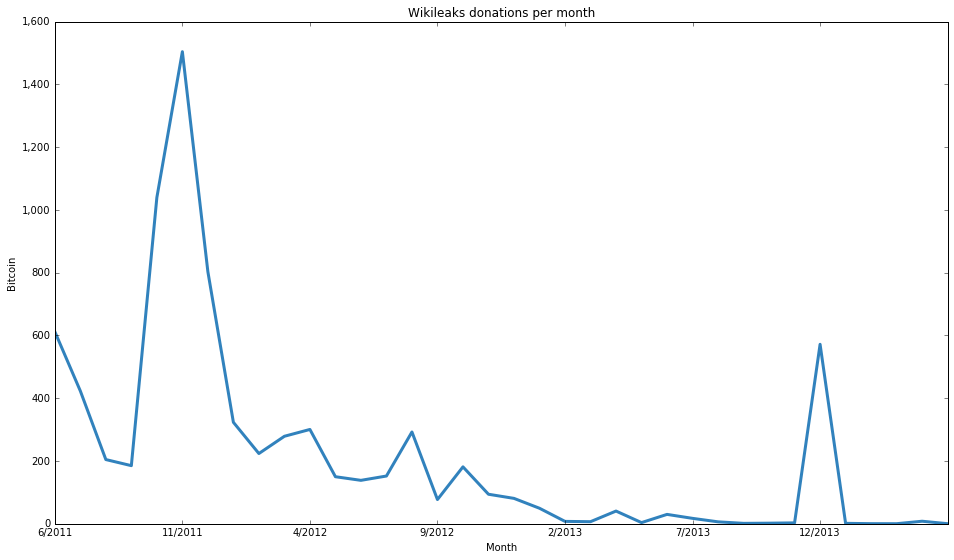

In [17]:
%pylab inline
# SUM TRANSACTIONS
transaction_sum = transactions[transactions.TO == 14012].groupby(['YEAR', 'MONTH'])["AMOUNT"].sum().reset_index()

# ADD LABELS
transaction_sum['LABEL'] = transaction_sum['MONTH'].astype(str) + "/" + transaction_sum['YEAR'].astype(str)

# plot
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(transaction_sum.AMOUNT, linewidth=3, color='#3182bd')
ax.set_title("Wikileaks donations per month")
ax.set_ylabel("Bitcoin")
ax.set_xlabel("Month")

transaction_sum_label = list(transaction_sum['LABEL'])
xticks = ax.get_xticks().astype(int)[:7]
ticklabels = list([transaction_sum_label[i] for i in xticks])
ax.set_xticklabels(ticklabels)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

fig.show()

In the following analyses we exclude newly minted coins, so we delete all transactions originating from "coinbase".

In [63]:
transactions = transactions[transactions.FROM != hash_indices["coinbase"]]

Take a first look at the descriptives for this dataset:

In [158]:
print(transactions.TIMESTAMP.describe())
print(transactions.AMOUNT.describe())

count                72891703
unique                 276408
top       2013-05-20 18:58:33
freq                    18647
first     2009-01-03 18:15:05
last      2013-12-23 09:08:32
Name: TIMESTAMP, dtype: object
count    7.289170e+07
mean     2.292638e+01
std      8.315798e+02
min      0.000000e+00
25%      1.000000e-02
50%      7.360361e-02
75%      1.000000e+00
max      5.000000e+05
Name: AMOUNT, dtype: float64


## Aggregated Bitcoin analyses

Let's begin our analyses by looking at some aggregated number. First, we plot the number of Bitcoin transactions per month. We can see that despite a lot of media coverage on the demise or bleak future of Bitcoin, the number of transactions experienced strong growth in the last years.

/Users/koehler/anaconda/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


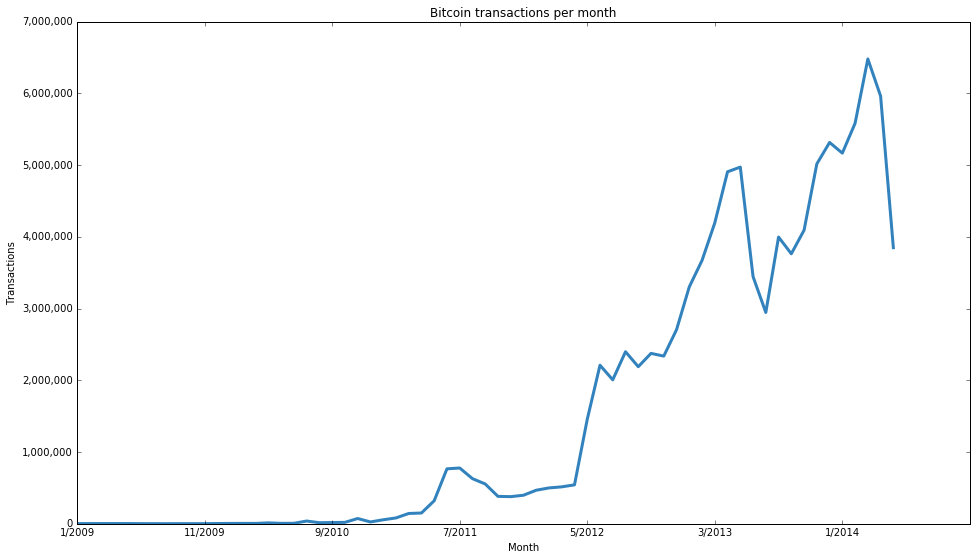

In [18]:
# COUNT TRANSACTIONS
transaction_count = transactions.groupby(['YEAR', 'MONTH']).size().reset_index()
transaction_count.columns = ["YEAR", "MONTH", "COUNT"]

# ADD LABELS
transaction_count['LABEL'] = transaction_count['MONTH'].astype(str) + "/" + transaction_count['YEAR'].astype(str)

# plot
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(transaction_count.COUNT, linewidth=3, color='#3182bd')
ax.set_title("Bitcoin transactions per month")
ax.set_ylabel("Transactions")
ax.set_xlabel("Month")

transaction_count_label = list(transaction_count['LABEL'])
xticks = ax.get_xticks().astype(int)[:7]
ticklabels = list([transaction_count_label[i] for i in xticks])
ax.set_xticklabels(ticklabels)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

fig.show()

On the other hand, if you look at the transaction volume in terms of Bitcoins sent between addresses, it had been growing until a huge spike in mid 2012 and then declined again.

/Users/koehler/anaconda/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


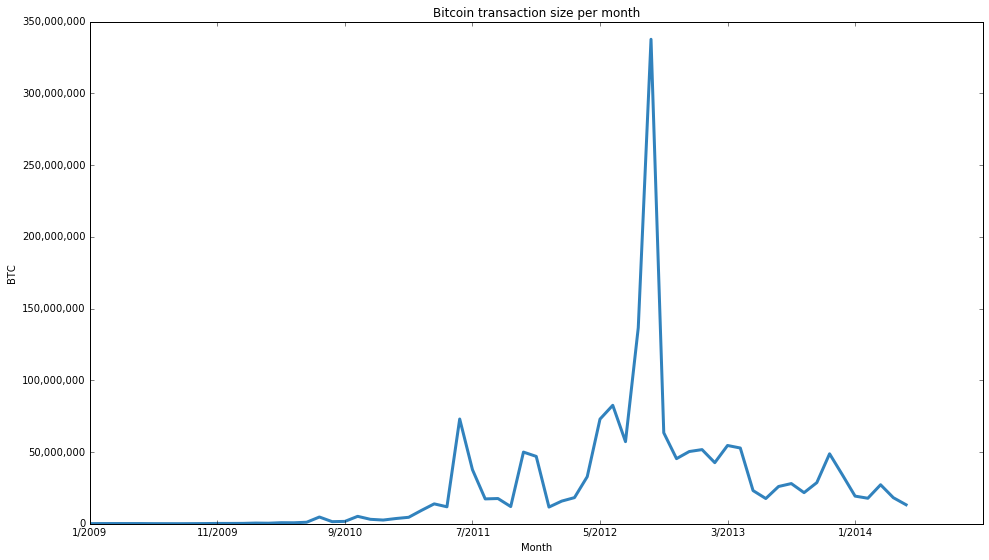

In [19]:
# SUM TRANSACTIONS
transaction_sum = transactions.groupby(['YEAR', 'MONTH'])["AMOUNT"].sum().reset_index()

# ADD LABELS
transaction_sum['LABEL'] = transaction_count['MONTH'].astype(str) + "/" + transaction_count['YEAR'].astype(str)

# plot
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(transaction_sum.AMOUNT, linewidth=3, color='#3182bd')
ax.set_title("Bitcoin transaction size per month")
ax.set_ylabel("BTC")
ax.set_xlabel("Month")

transaction_sum_label = list(transaction_sum['LABEL'])
xticks = ax.get_xticks().astype(int)[:7]
ticklabels = list([transaction_sum_label[i] for i in xticks])
ax.set_xticklabels(ticklabels)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

fig.show()

Finally, the last aggregate measure to look at is the average transaction size per month. This is a curve with strong spikes: there are months that have very high average volumes and months with very low average transaction volumes. But in general, it has declined in the last years. But: this is transaction volume measured in Bitcoin. To fully interpret this development, we also have to look at the corresponding valuations in non-digital currency.

/Users/koehler/anaconda/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


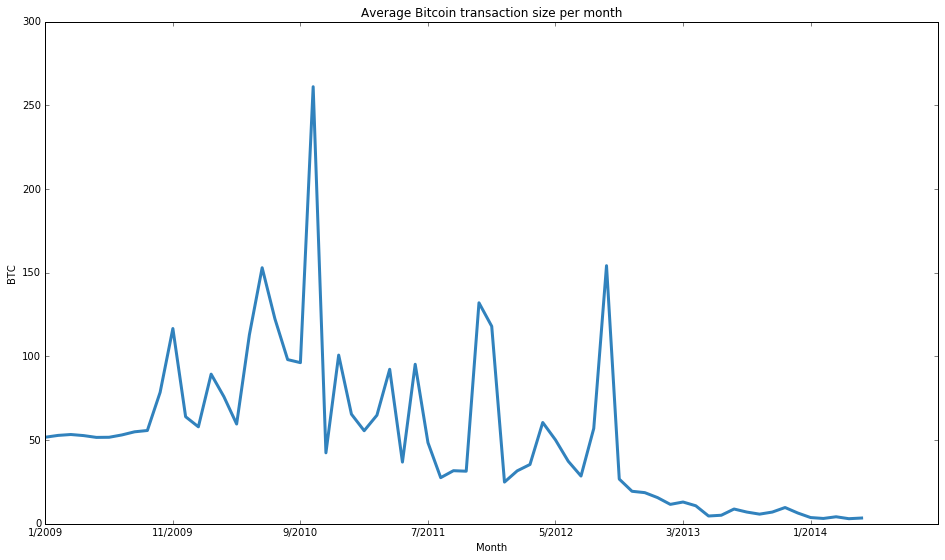

In [20]:
# AVG TRANSACTIONS
transaction_avg = transactions.groupby(['YEAR', 'MONTH'])["AMOUNT"].mean().reset_index()
transaction_avg.columns = ["YEAR", "MONTH", "AVG"]

# ADD LABELS
transaction_avg['LABEL'] = transaction_avg['MONTH'].astype(str) + "/" + transaction_avg['YEAR'].astype(str)

# plot
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(transaction_avg.AVG, linewidth=3, color='#3182bd')
ax.set_title("Average Bitcoin transaction size per month")
ax.set_ylabel("BTC")
ax.set_xlabel("Month")

transaction_avg_label = list(transaction_avg['LABEL'])
xticks = ax.get_xticks().astype(int)[:7]
ticklabels = list([transaction_avg_label[i] for i in xticks])
ax.set_xticklabels(ticklabels)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

fig.show()

# Bitcoin user network analyses

Next, we'll analyze the user network with methods from social network analysis. Here we take a look at the connections that are linking transactions and therefore also users together. In the Blockchain there are two different networks:

- The *transaction network* that links transactions (because every transaction has one or more transactions as its inputs
- The *user network* that links users together that have been exchanged Bitcoins. Here we use our newly created user ids that already link inputs controlled by the same user together

![title](./networks_blockchain.png "Blockchain networks")


## Network measures

To calculate the following network measures for the complete Blockchain user network, we use the Python module [graph_tool](https://graph-tool.skewed.de/) because it uses the memory much more efficiently than networkx. Later analyses of smaller networks are created with [networkx](https://networkx.github.io/) because its API is much easier to work with.

In [6]:
from graph_tool.all import *

/Users/koehler/anaconda/lib/python3.4/site-packages/graph_tool/draw/cairo_draw.py:1468: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


We create a new directed graph and load our user connections into the graph as an edgelist.

In [ ]:
g = Graph(directed=True)
edgelist = [(i[1].FROM,i[1].TO) for i in transactions.iterrows()]
g.add_edge_list(edgelist)

Then, we can compute the most important network measures that tell us something about which nodes are well connected, most influential or important in other respect:

![title](./network_metrics.png "Network measures")

In [ ]:
indeg = g.degree_property_map('in')
outdeg = g.degree_property_map('out')
deg = g.degree_property_map('total')
pr = graph_tool.centrality.pagerank(g)
metrics = pd.DataFrame({"InDegree": indeg.a, "OutDegree": outdeg.a, "Degree": deg.a, 
                        "PageRank": pr.a, "Name": ""})

Let's look at the nodes with the highest PageRank:

In [ ]:
metrics.sort("PageRank", ascending=False).head(20)

Now, we try to identify some of the most influential nodes by looking at their addresses. One thing is immediately visible: The most influential nodes have a lot of public hash addresses associated with them. So many, that they do not appear to be "human" addresses. The top address has ... keys associated with it.

In [107]:
hashes_list.loc[25870].KEYS[:1000]

'1KpJ8rLxayJpgksKfRRjCo123JSLhSFFiM,1sRzbV3KJNktJQqcsn1CVaJdZmP7JHwcn,18NchB1BTWmWzs36bq4PpEDuf3NyMmgfi6,1LLArkczRrnGKtSPufEDTsTaM1hTyx8idf,1Cwa37FXDRtSmEjZJtABoDscLTk4V5q2Ja,1CLnXiD4VAGBTow1BLGQwyQkXN89M7SuqD,1eEpHpAyx9HW7a3aFWcLs41MLRoWNBvv1,1LTLVEqCR17rFzjWZ6bvh6n6qxgcC7sjH6,1MxeLVCeHt2c5SFpjVq6ecGwMhnpfonb93,1CzkvBG977JjaMXtcw2JrMLqcXombB8bFL,1P4eorjAcH8Py3UyrUguUvDJ3Mrk2LH2Mv,1FdHKFU2aP7kJiDQPgPiubybX3m6vuPHfW,1PSaiRs4cBhqpydYPoLBgDdZWXttegy7q3,17NQdJmTQPD3NuA5bMXh9Nmp5FhYWudxfp,1HDn1GuuhBJ8gX83196yv2MR7tveGjPbVQ,17bzf1BjcMFgaMjXRWwJW4wbdMUd86SRBb,1B4akDwYNbkMYknC8DpQ1dnJiHznmugqhc,1PZHisfNqWpMTsoyoTAZpg4JATn14aAnYM,1P2tQeEauLmj5kNUyU9vAGAMgyxSWzPyWy,1dicec9k7KpmQaA8Uc8aCCxfWnwEWzpXE,1qtuBmm8jRrECUvSsCvCd1QTXixTfo2cD,1Nxuj2qAtWGNYyk8dMUSHs9R8PGvP4sfzY,19YV1cEmZWoms9jZTt35ut9aL31R5zCw8t,1JGBK1gsV2Sbbe2oK5rrmkwuCHvvTTrCZt,1AqEYLgDjw5B5yq4z9XBQQWbqc91zBocoq,1EQ3qfqboNDmMHMPRf6a1q1LZ5JHj33yDQ,1KJqHPbc4ZKYwG3EHV4PRfQMnP8aUk7KLg,1Q9gGyKayF1jd7V6MRPh5MD3yDJr8enVse,1Q4krEZuVMqXEo2n1p7sbW5

Fortunately, if you search Google for these hash keys, you get some results very fast. Or, you just take a look at the website walletexplorer.com that collects known wallet addresses and can be queried:

In [105]:
from IPython.display import HTML
HTML('<iframe src=https://www.walletexplorer.com/wallet/Bitcoin.de-old?from_address=14Xr7ZJSLr6LgC4VoU91gf6xLeqMGxHLAR width=100% height=350></iframe>')

Here's the sites or wallets associated with most of the 20 top PageRank nodes in the Bitcoin user network:

In [100]:
# https://www.walletexplorer.com
metrics.loc[25870,'Name'] = "SatoshiDICE"
metrics.loc[135,'Name'] = "BTC-e.com-old"
metrics.loc[59,'Name'] = "SilkRoadMarketplace"
metrics.loc[98,'Name'] = "MtGoxAndOthers"
metrics.loc[146,'Name'] = "BitPay.com-old"
metrics.loc[17,'Name'] = "MtGoxAndOthers"
metrics.loc[53,'Name'] = "Bitstamp.net-old"
metrics.loc[78,'Name'] = "Cryptsy.com-old"
metrics.loc[28,'Name'] = "Instawallet.org"
metrics.loc[361,'Name'] = "LocalBitcoins.com"
metrics.loc[287,'Name'] = "SilkRoad2Market"
metrics.loc[694,'Name'] = "Cex.io"
metrics.loc[420,'Name'] = "BitcoinFog"
metrics.loc[29,'Name'] = "BTC-e.com-old"
metrics.loc[12083,'Name'] = "BitZillions.com"
metrics.loc[1673710,'Name'] = "BTC-e.com-old"
metrics.loc[432,'Name'] = "BitZino.com"
metrics.loc[664,'Name'] = "Bitcoin.de-old"

In [94]:
metrics.sort("PageRank", ascending=False).head(20)

           Degree  InDegree  OutDegree  PageRank                 Name
25870    25263847  12641091   12622756  0.023951          SatoshiDICE
135       1446765   1142934     303831  0.014809        BTC-e.com-old
59        1230011    916526     313485  0.014794  SilkRoadMarketplace
98        2360326   1475615     884711  0.013563       MtGoxAndOthers
146        538433    481019      57414  0.005846       BitPay.com-old
17        6031532   2527757    3503775  0.005681       MtGoxAndOthers
53         688542    367090     321452  0.004776     Bitstamp.net-old
78         933695    519674     414021  0.004423      Cryptsy.com-old
28         601260    479177     122083  0.004124      Instawallet.org
19         300213    186030     114183  0.003143                     
361        663690    287250     376440  0.003036    LocalBitcoins.com
287        419563    274561     145002  0.002778      SilkRoad2Market
694        480032    332886     147146  0.002592               Cex.io
420        128379   

/Users/koehler/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


/Users/koehler/anaconda/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


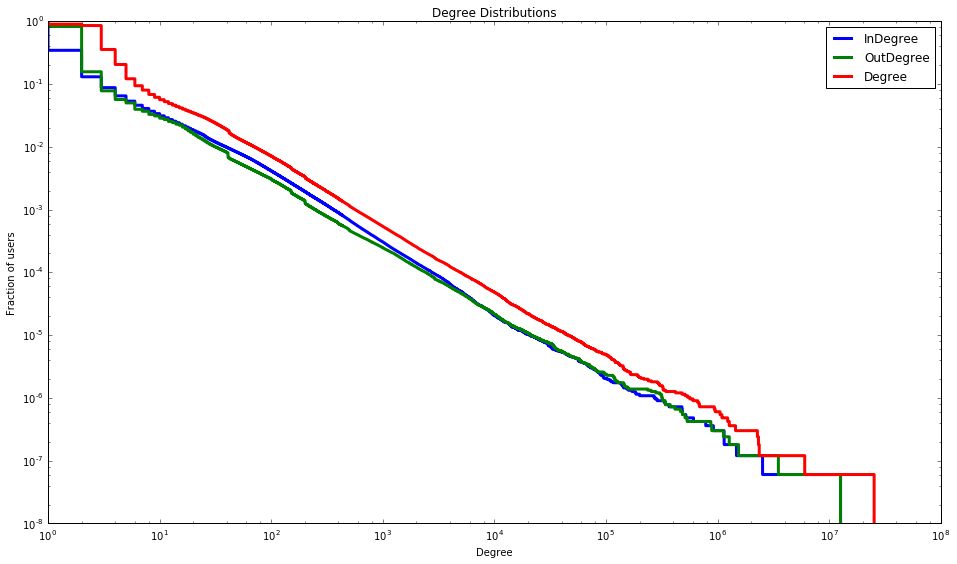

In [47]:
fig, ax = plt.subplots(figsize=(16, 9))

for metric in ["OutDegree", "InDegree", "Degree"]:
    counts = np.bincount(metrics[metric])
    ecdf = np.cumsum(counts) / float(len(metrics.index))
    ax.step(range(len(ecdf)), 1 - ecdf, lw=3, where='post', label=metric)

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Degree")
ax.set_ylabel("Fraction of users")
ax.set_title("Degree Distributions")
fig.show()

## Network visualization of a single day on Bitcoin

Next, we take a look at a single day on Bitcoin: October 25, 2013. We extract all transactions between users for this day and visualize the resulting user network. What is special about this network?

In [5]:
single_day = transactions[(transactions.YEAR == 2013) & (transactions.MONTH == 10) & (transactions.DAY == 25)]

In [6]:
single_day.head()

,FROM,TO,AMOUNT,TIMESTAMP,YEAR,MONTH,DAY
63005283,16178794,3240,25.130314,2013-10-25 00:04:51,2013,10,25
63005284,14606608,507,0.260113,2013-10-25 00:04:51,2013,10,25
63005285,14606608,14606608,18.953987,2013-10-25 00:04:51,2013,10,25
63005286,98,3403359,29.824183,2013-10-25 00:04:51,2013,10,25
63005287,98,11198972,36.400623,2013-10-25 00:04:51,2013,10,25


In [7]:
import networkx as nx
G = nx.from_pandas_dataframe(single_day, 'FROM', 'TO', ['AMOUNT'], nx.DiGraph())

In [8]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 47933\nNumber of edges: 84314\nAverage in degree:   1.7590\nAverage out degree:   1.7590'

In [35]:
# https://www.walletexplorer.com
known_nodes = {25870: "SatoshiDICE", 135: "BTC-e.com-old", 59: "SilkRoadMarketplace", 98: "MtGoxAndOthers", 
               146: "BitPay.com-old", 17: "MtGoxAndOthers", 53: "Bitstamp.net-old", 78: "Cryptsy.com-old",
               28: "Instawallet.org", 361: "LocalBitcoins.com", 287: "SilkRoad2Market", 694: "Cex.io", 
               420: "BitcoinFog", 29: "BTC-e.com-old", 12083: "BitZillions.com", 1673710: "BTC-e.com-old",
               432: "BitZino.com", 664: "Bitcoin.de-old", 14012: "Wikileaks", 7996984: "FBI (DPR)"}

In [40]:
node_labels = {}
for n in G.nodes():
    if n in known_nodes:
        node_labels[n] = known_nodes[n]
    else:
        node_labels[n] = "."

In [41]:
nx.set_node_attributes(G, "label", node_labels)

In [42]:
nx.write_graphml(G, "./blockchain.graphml")

# Structural types of Bitcoin transactions
There are a few typical structural patterns of transaction flows that you can find all over the Blockchain. See also Danno Ferrin's ["A Preliminary Field Guide for Bitcoin Transaction Patterns"](http://t.co/CNdTDiA7LF)

In [109]:
# Hierarchical Layout from 
# http://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3

def hierarchy_pos(G, root, width = 2., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5 ):
    '''If there is a cycle that is reachable from root, then result will not be a hierarchy.

       G: the graph
       root: the root node of current branch
       width: horizontal space allocated for this branch - avoids overlap with other branches
       vert_gap: gap between levels of hierarchy
       vert_loc: vertical location of root
       xcenter: horizontal location of root
    '''

    def h_recur(G, root, width= width, vert_gap = vert_gap, vert_loc = vert_loc, xcenter = 0.5, 
                  pos = None, parent = None, parsed = [] ):
        if(root not in parsed):
            parsed.append(root)
            if pos == None:
                pos = {root:(xcenter, vert_loc)}
            else:
                pos[root] = (xcenter, vert_loc)
            neighbors = G.neighbors(root)
            if parent != None:
                if parent in neighbors:
                    neighbors.remove(parent)
            if len(neighbors)!=0:
                dx = width/len(neighbors) 
                nextx = xcenter - width/2 - dx/2
                for neighbor in neighbors:
                    nextx += dx
                    pos = h_recur(G,neighbor, width = dx, vert_gap = vert_gap, 
                                  vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos,
                                  parent = root, parsed = parsed)
        return pos

    return h_recur(G, root, width = width, vert_gap = vert_gap, vert_loc = vert_loc, xcenter = 0.)

## The first Bitcoin transaction ever
This is the first Bitcoin transaction where Satoshi Nakamoto sends Hal Finney 10 BTC and transfers the remaining 40 BTC back to his own address. This structural pattern is called "spend and change" because some amount of Bitcoins are spent in this transaction and the rest is returned to the original address.

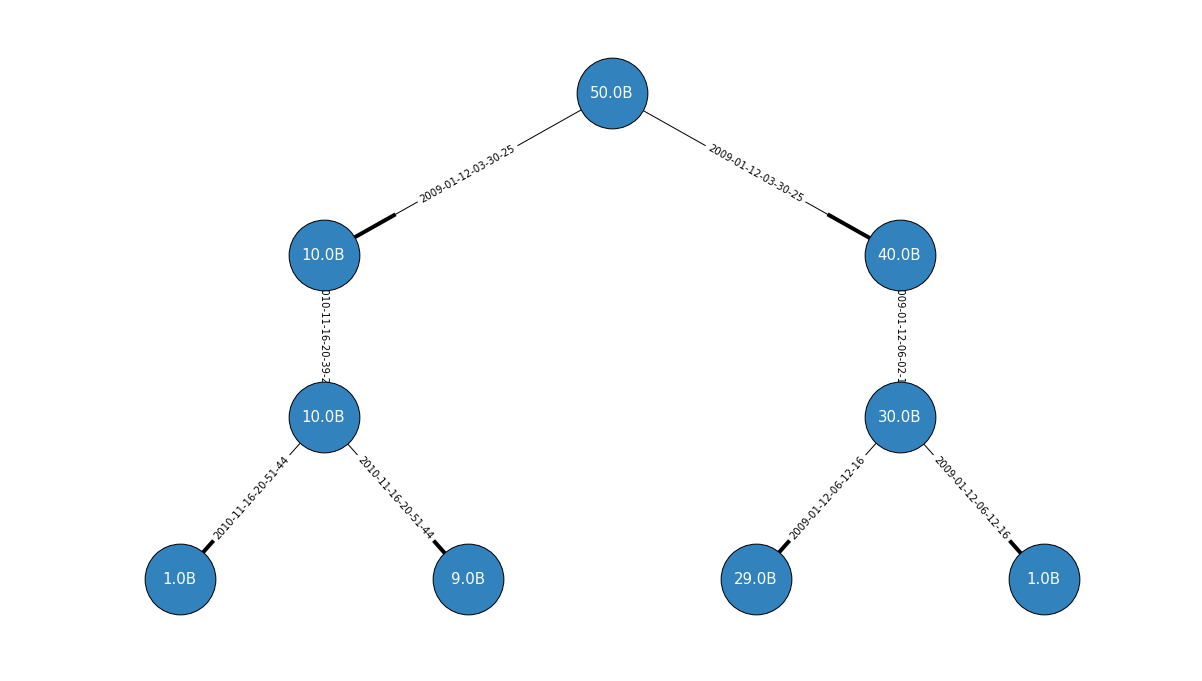

In [106]:
root = "f4184fc596403b9d638783cf57adfe4c75c605f6356fbc91338530e9831e9e16"
nodes = [root]
for i in range(3):
    new = list(raw_transactions.TO[raw_transactions.FROM.isin(nodes)])
    nodes = nodes + new
network = raw_transactions[raw_transactions.FROM.isin(nodes) & raw_transactions.TO.isin(nodes)]
G = nx.from_pandas_dataframe(network, 'FROM', 'TO', create_using=nx.DiGraph())
pos = hierarchy_pos(G, root)
plt.figure(figsize=(16,9))

labels = {}
for g in G.nodes():
    labels[g] = str(round(float(transaction_values.VALUE[transaction_values.TX == g]),1)) + "B"

edge_labels = {}
for g in G.edges(data=True):
    edge_labels[(g[0],g[1])] = transaction_values.TIMESTAMP[transaction_values.TX == g[0]].values[0]
    
nx.draw(G, pos, with_labels=False, node_size=5000, node_color="#3182bd")
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, arrows=True)
nx.draw_networkx_labels(G,pos,labels=labels,font_color="#ffffff",font_size=15)
plt.show()

## The Pizza Transaction
This is the famous pizza transaction, when Laszlo ordered a Pizza for 10,000 BTC in May 2010. This pizza money has been distributed from transaction to transaction, so parts of it are still in many Bitcoin accounts.

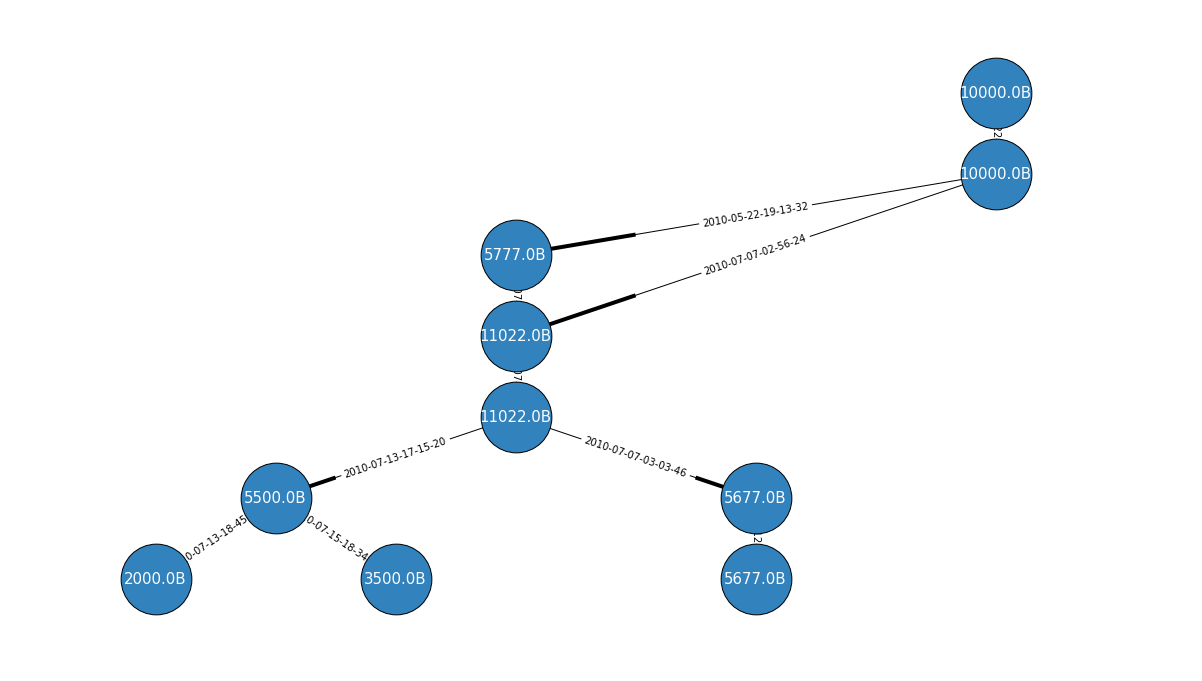

In [64]:
root = "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d"
nodes = [root]
for i in range(4):
    new = list(raw_transactions.TO[raw_transactions.FROM.isin(nodes)])
    nodes = nodes + new
network = raw_transactions[raw_transactions.FROM.isin(nodes)]
G = nx.from_pandas_dataframe(network, 'FROM', 'TO', ['TIMESTAMP'], nx.DiGraph())
pos = hierarchy_pos(G, root)
plt.figure(figsize=(16,9))
labels = {}
for g in G.nodes():
    labels[g] = str(round(float(transaction_values[g]),1)) + "B"

edge_labels = {}
for g in G.edges(data=True):
    edge_labels[(g[0],g[1])] = g[2]["TIMESTAMP"]
    
nx.draw(G, pos, with_labels=False, node_size=5000, node_color="#3182bd")
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw_networkx_labels(G,pos,labels=labels,font_color="#ffffff",font_size=15)
plt.show()

## The Silk Road FBI seizures
Here Bitcoins from multiple addresses are combined into a new (or a previously existing) address. The following example are the Silk Road seizures, where the FBI seized funds from Silk Road's Dread Pirate Roberts (DPR) and combined them into wallets of 324 Bitcoins each. This pattern is called "consoliation".

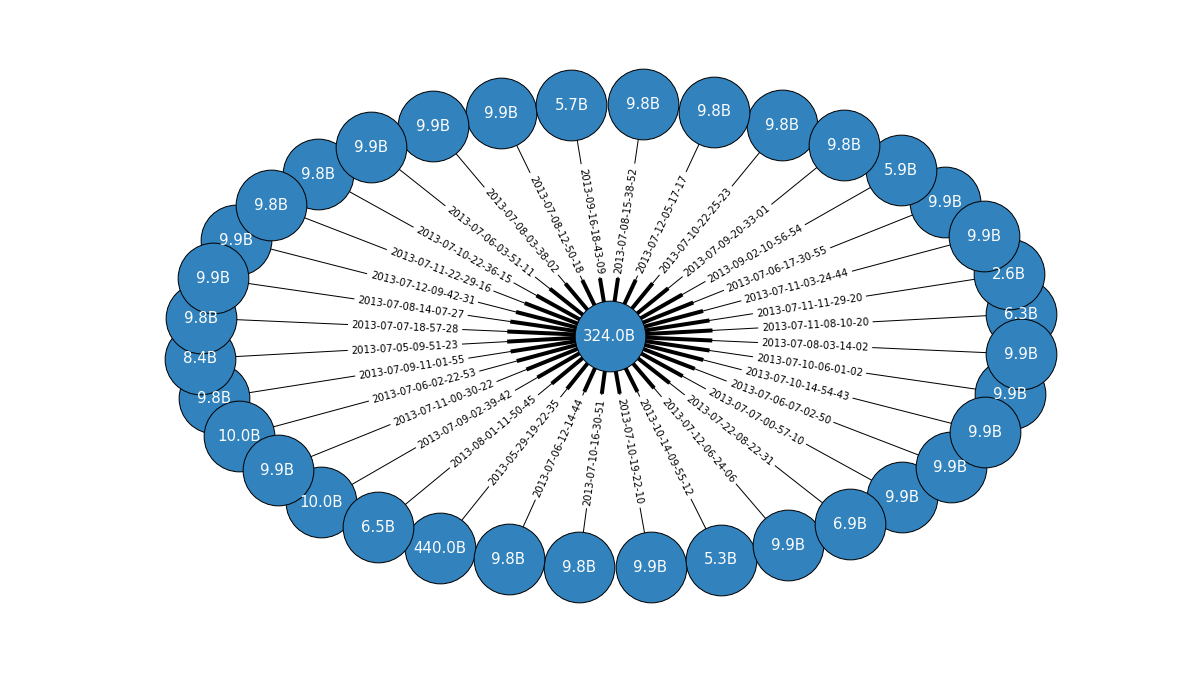

In [122]:
root = "3ae43bb0a8e4cc3a345a7a2a688217bcb8d9f7e9001263930cd23e9b3b7364c6"
network = raw_transactions[raw_transactions.TO == root]
G = nx.from_pandas_dataframe(network, 'FROM', 'TO', create_using=nx.DiGraph())
pos = nx.spring_layout(G)
plt.figure(figsize=(16,9))

labels = {}
for g in G.nodes():
    labels[g] = str(round(transaction_values.VALUE[transaction_values.TX == g].values[0],1)) + "B"

edge_labels = {}
for g in G.edges(data=True):
    edge_labels[(g[0],g[1])] = transaction_values.TIMESTAMP[transaction_values.TX == g[0]].values[0]
    
nx.draw(G, pos, with_labels=False, node_size=5000, node_color="#3182bd")
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, arrows=True)
nx.draw_networkx_labels(G,pos,labels=labels,font_color="#ffffff",font_size=15)
plt.show()

## Transaction chains / "Peeling"
Very often from larger amounts of Bitcoins round amounts of Bitcoins (e.g. 50,000 BTC) are subsequently "peeled" off the original amount. These change addresses can also feed back into another peeling chain. The example is assumed to be a peeling chain controlled by Mt. Gox.

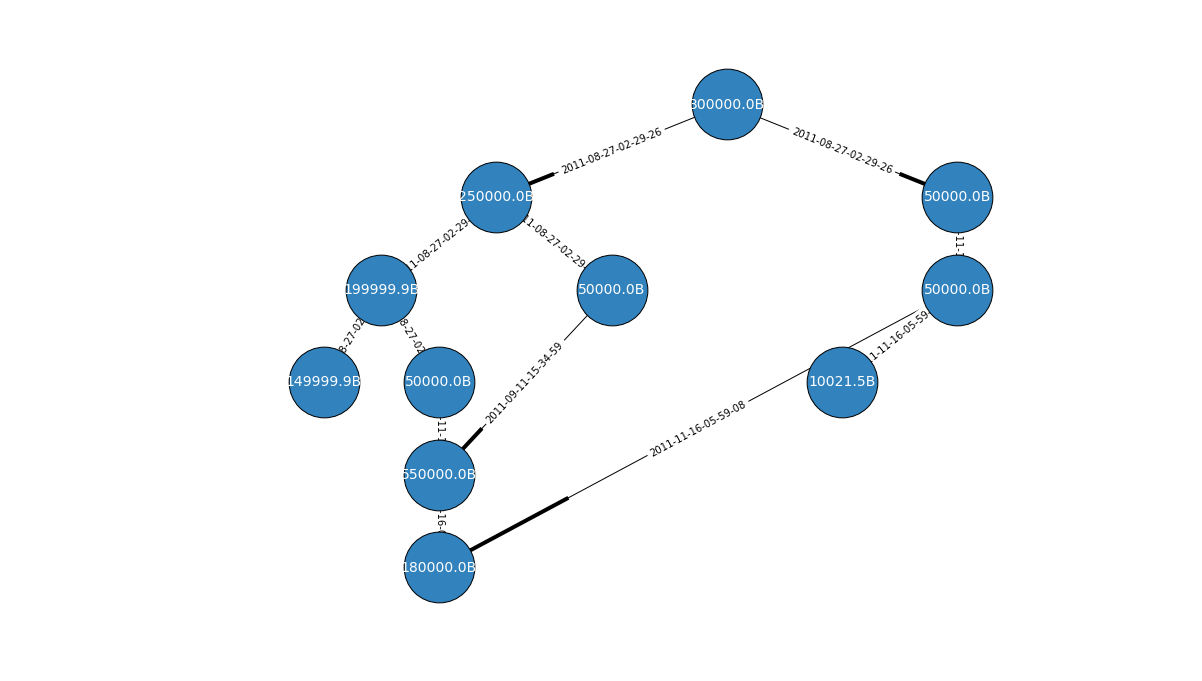

In [125]:
root = "012c509a06ca09146e58fe01a4bb155105eaa19ea9d1fc35275ae40ce5e9c459"
nodes = [root]
for i in range(3):
    new = list(raw_transactions.TO[raw_transactions.FROM.isin(nodes)])
    nodes = nodes + new
network = raw_transactions[raw_transactions.FROM.isin(nodes) & raw_transactions.TO.isin(nodes)]
G = nx.from_pandas_dataframe(network, 'FROM', 'TO', create_using=nx.DiGraph())
pos = hierarchy_pos(G, root)
plt.figure(figsize=(16,9)) 

labels = {}
for g in G.nodes():
    labels[g] = str(round(transaction_values.VALUE[transaction_values.TX == g].values[0],1)) + "B"

edge_labels = {}
for g in G.edges(data=True):
    edge_labels[(g[0],g[1])] = transaction_values.TIMESTAMP[transaction_values.TX == g[0]].values[0]

nx.draw(G, pos, with_labels=False, node_size=5000, node_color="#3182bd")
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, arrows=True)
nx.draw_networkx_labels(G,pos,labels=labels,font_color="#ffffff",font_size=14)
plt.show()

## The 180,000 BTC Pyramid Scheme
Here's an interesting transaction where 180,000 BTC are subsequently split into smaller amounts.

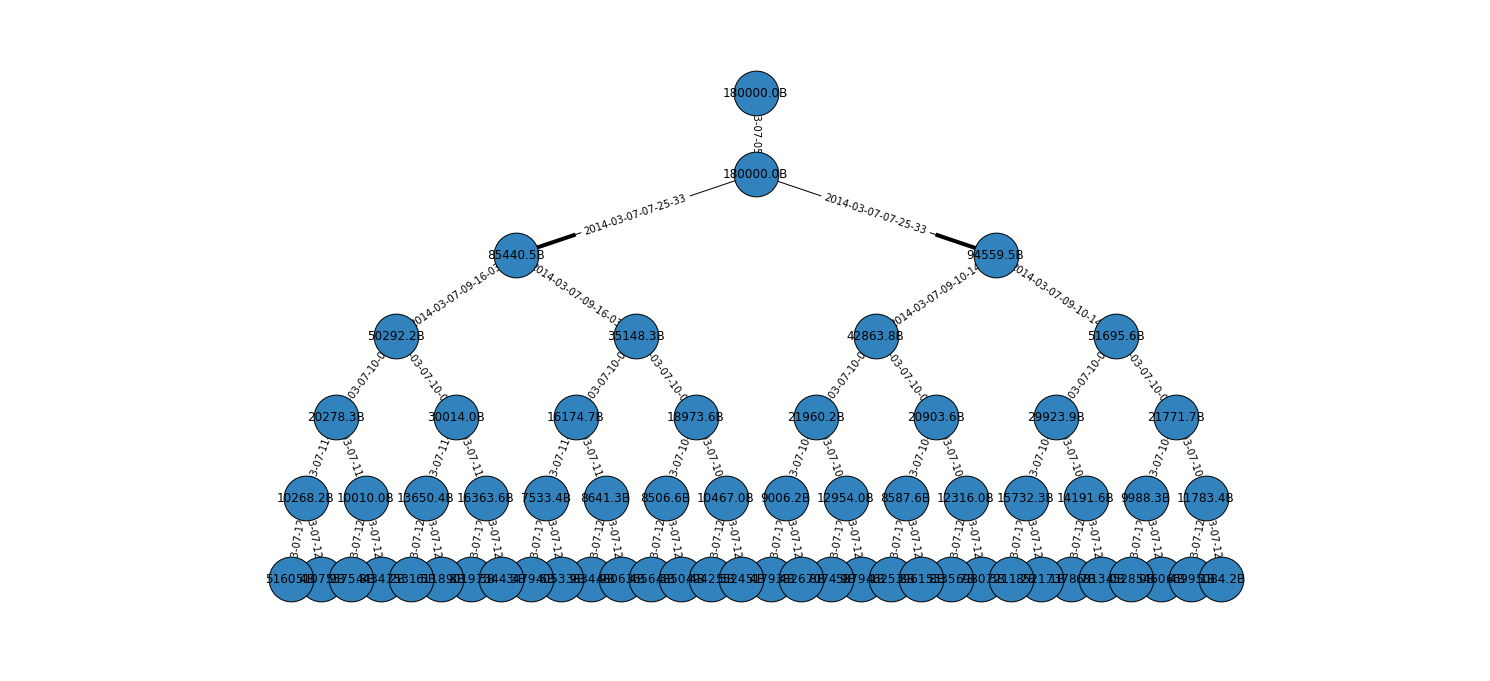

In [131]:
root = "4ee89f7cf824a85ad5f11d52604ffdebe9f01302bcea8ddec0af450f9185ddf1"
nodes = [root]
for i in range(5):
    new = list(raw_transactions.TO[raw_transactions.FROM.isin(nodes)])
    nodes = nodes + new
network = raw_transactions[raw_transactions.FROM.isin(nodes)]
G = nx.from_pandas_dataframe(network, 'FROM', 'TO', create_using=nx.DiGraph())
pos = hierarchy_pos(G, root)
plt.figure(figsize=(20,9)) 

labels = {}
for g in G.nodes():
    labels[g] = str(round(transaction_values.VALUE[transaction_values.TX == g].values[0],1)) + "B"

edge_labels = {}
for g in G.edges(data=True):
    edge_labels[(g[0],g[1])] = transaction_values.TIMESTAMP[transaction_values.TX == g[0]].values[0]

nx.draw(G, pos, with_labels=False, node_size=2000, node_color="#3182bd")
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, arrows=True)
nx.draw_networkx_labels(G,pos,labels=labels,font_color="#000000",font_size=12)
plt.show()

## Examining the Allinvain robbery

Here we can see the transactions where someone allgedly stole 25,000 Bitcoin from allinvain. https://bitcointalk.org/index.php?topic=16457.0

![title](./allinvain.png "Allinvain heist")

In [ ]:
root = "4885ddf124a0f97b5a3775a12de0274d342d12842ebe59520359f976721ac8c3"
nodes = [root]
for i in range(3):
    new = list(raw_transactions.TO[raw_transactions.FROM.isin(nodes)])
    nodes = nodes + new
network = raw_transactions[raw_transactions.FROM.isin(nodes)]
G = nx.from_pandas_dataframe(network, 'FROM', 'TO', create_using=nx.DiGraph())
pos = hierarchy_pos(G, root)
plt.figure(figsize=(16,9)) 

labels = {}
for g in G.nodes():
    labels[g] = str(round(transaction_values.VALUE[transaction_values.TX == g].values[0],1)) + "B"

edge_labels = {}
for g in G.edges(data=True):
    edge_labels[(g[0],g[1])] = transaction_values.TIMESTAMP[transaction_values.TX == g[0]].values[0]

nx.draw(G, pos, with_labels=False, node_size=2000, node_color="#3182bd")
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, arrows=True)
nx.draw_networkx_labels(G,pos,labels=labels,font_color="#000000",font_size=12)
plt.show()

In [69]:
root = int(hashes_list[hashes_list.KEYS.str.contains("1J18yk7D353z3gRVcdbS7PV5Q8h5w6oWWG")].USER)

In [79]:
nodes = [root,7074108,13313146,27461,2425534]

for i in range(1):
    new = list(transactions.TO[transactions.FROM.isin(nodes) & (transactions.YEAR == 2011) & 
                               (transactions.MONTH == 6) & (transactions.DAY >= 12)])
    nodes = nodes + new

network = transactions[transactions.FROM.isin(nodes) & transactions.TO.isin(nodes) & 
                       (transactions.YEAR == 2011) & (transactions.MONTH == 6) & (transactions.DAY >= 12)]

In [ ]:
G = nx.from_pandas_dataframe(network, 'FROM', 'TO', ['AMOUNT', 'TIMESTAMP'], create_using=nx.DiGraph())

pos = nx.spring_layout(G)
plt.figure(figsize=(12,12))

edge_labels = {}
for g in G.edges(data=True):
    edge_labels[(g[0],g[1])] = str(g[2]["AMOUNT"])
    
node_colors = []
for g in G.nodes():
    if g == 168768:
        node_colors.append("r")
    elif g == 7074108:
        node_colors.append("g")
    else:
        node_colors.append("#3182bd")
    
nx.draw(G, pos, with_labels=True, node_size=2500, node_color=node_colors, font_color="#ffffff")
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, arrows=True)
nx.draw_networkx_labels(G,pos,labels=labels,font_color="#ffffff",font_size=13)
plt.show()